# Vietnamese Accent Model - Colab Notebook

- Data loading and preprocessing
- Model training
- Accent prediction
- Model evaluation


## 0. Setup Environment

First, let's install the necessary dependencies:

In [1]:
# Install required packages
# !pip install nltk==3.5 scikit-learn==1.2.2 dill~=0.3.7 pandas~=2.0.3 matplotlib~=3.7.5 seaborn~=0.13.2 tqdm~=4.66.0 requests~=2.31.0

# Download NLTK punkt tokenizer
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## 1. Directory Structure Setup

Next, let's set up the directory structure for our project:

In [2]:
import os

# Create project directories
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
MODEL_DIR = os.path.join(BASE_DIR, "models")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

print(f"Project directories created:")
print(f"- Data dir: {DATA_DIR}")
print(f"- Model dir: {MODEL_DIR}")
print(f"- Plots dir: {PLOTS_DIR}")

Project directories created:
- Data dir: /content/data
- Model dir: /content/models
- Plots dir: /content/plots


In [3]:
print(os.cpu_count())

2


## 2. Define Utility Functions (utils.py)

In [4]:
# Porting utils.py
import re
import string
from nltk import word_tokenize

VN_SYLLABLES_FILE_PATH = os.path.join(DATA_DIR, "vn_syllables.txt")

def tokenize(doc: str) -> list[str]:
    tokens = word_tokenize(doc.lower())
    # Allow underscore, remove other punctuation
    table = str.maketrans('', '', string.punctuation.replace("_", ""))
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word]  # Remove empty strings
    return tokens

def remove_vn_accent(word: str) -> str:
    word = word.lower()
    word = re.sub(r'[áàảãạăắằẳẵặâấầẩẫậ]', 'a', word)
    word = re.sub(r'[éèẻẽẹêếềểễệ]', 'e', word)
    word = re.sub(r'[óòỏõọôốồổỗộơớờởỡợ]', 'o', word)
    word = re.sub(r'[íìỉĩị]', 'i', word)
    word = re.sub(r'[úùủũụưứừửữự]', 'u', word)
    word = re.sub(r'[ýỳỷỹỵ]', 'y', word)
    word = re.sub(r'đ', 'd', word)
    return word

def gen_accents_word(word: str, syllables_path: str = VN_SYLLABLES_FILE_PATH) -> set[str]:
    """
    Sinh văn bản tự động với file vn_syllables.txt
    """
    normalized_input_word = word.lower()
    word_no_accent = remove_vn_accent(normalized_input_word)
    all_accent_word = {normalized_input_word}  # Start with the input word (normalized)

    if not os.path.exists(syllables_path):
        print(f"Warning: Syllables file not found at {syllables_path}. "
              f"Accent generation will be limited to the input word: '{word}'.")
        if word_no_accent != normalized_input_word:
            all_accent_word.add(word_no_accent)
        return all_accent_word

    try:
        with open(syllables_path, 'r', encoding='utf-8') as f:
            for w_line in f.read().splitlines():
                w_line_lower = w_line.lower()  # Normalize file content
                if remove_vn_accent(w_line_lower) == word_no_accent:
                    all_accent_word.add(w_line_lower)
    except Exception as e:
        print(f"Error reading or processing syllables file {syllables_path}: {e}")

    return all_accent_word

# Test the utility functions
print("Tokenize example:", tokenize("Đây_là một câu, ví dụ."))
print("Remove accent example:", remove_vn_accent("hoàng"))

Tokenize example: ['đây_là', 'một', 'câu', 'ví', 'dụ']
Remove accent example: hoang


## 3. Define Data Loader (data_loader.py)

In [5]:
# Porting data_loader.py
import requests
import zipfile
from tqdm import tqdm
import random
import multiprocessing as mp

# Data paths configuration
TRAIN_ZIP_URL = "https://github.com/hoanganhpham1006/Vietnamese_Language_Model/raw/master/Train_Full.zip"
TRAIN_ZIP_NAME = "Train_Full.zip"
TRAIN_ZIP_PATH = os.path.join(DATA_DIR, TRAIN_ZIP_NAME)
TRAIN_EXTRACT_PATH = os.path.join(DATA_DIR, "Train_Full")

SYLLABLES_URL = "https://gist.githubusercontent.com/hieuthi/0f5adb7d3f79e7fb67e0e499004bf558/raw/135a4d9716e49a981624474156d6f247b9b46f6a/all-vietnamese-syllables.txt"
SYLLABLES_NAME = "vn_syllables.txt"
SYLLABLES_PATH = os.path.join(DATA_DIR, SYLLABLES_NAME)

def download_file(url, local_path, desc="Downloading file"):
    """
    Download a file from the given URL to the specified local path.
    """
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total_size = int(r.headers.get('content-length', 0))
        chunk_size = 8192

        with open(local_path, 'wb') as f, tqdm(
            desc=desc,
            total=total_size,
            unit='B', unit_scale=True, unit_divisor=1024,
        ) as bar:
            for chunk in r.iter_content(chunk_size=chunk_size):
                size = f.write(chunk)
                bar.update(size)
    return local_path

def download_and_prepare_data():
    """
    Download and extract the training data and syllables file.
    """
    os.makedirs(DATA_DIR, exist_ok=True)

    # Download syllables file
    if not os.path.exists(SYLLABLES_PATH):
        print(f"Downloading Vietnamese syllables file to {SYLLABLES_PATH}...")
        download_file(SYLLABLES_URL, SYLLABLES_PATH, desc="Downloading syllables file")
    else:
        print(f"Syllables file already exists at {SYLLABLES_PATH}")

    # Download training data
    if not os.path.exists(TRAIN_EXTRACT_PATH) or not os.listdir(TRAIN_EXTRACT_PATH):
        if not os.path.exists(TRAIN_ZIP_PATH):
            print(f"Downloading training data to {TRAIN_ZIP_PATH}...")
            download_file(TRAIN_ZIP_URL, TRAIN_ZIP_PATH, desc="Downloading training data")

        print(f"Extracting training data to {TRAIN_EXTRACT_PATH}...")
        os.makedirs(TRAIN_EXTRACT_PATH, exist_ok=True)
        with zipfile.ZipFile(TRAIN_ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(DATA_DIR)
    else:
        print(f"Training data already exists at {TRAIN_EXTRACT_PATH}")

    return check_data_exists()

def check_data_exists():
    """kiểm tra xem dữ liệu đã có chưa"""
    os.makedirs(DATA_DIR, exist_ok=True)
    print(f"Data directory configured at: {DATA_DIR}")
    all_data_exists = True
    if not os.path.exists(TRAIN_EXTRACT_PATH) or not os.listdir(TRAIN_EXTRACT_PATH):
        print(f"Warning: Training data directory {TRAIN_EXTRACT_PATH} is missing or empty.")
        print("Please ensure you have downloaded and extracted 'Train_Full.zip' into the 'data/Train_Full' directory.")
        all_data_exists = False
    else:
        print(f"Training data found at: {TRAIN_EXTRACT_PATH}")

    if not os.path.exists(SYLLABLES_PATH):
        print(f"Warning: Vietnamese syllables file {SYLLABLES_PATH} is missing.")
        print("Please ensure you have 'vn_syllables.txt' in the 'data' directory.")
        all_data_exists = False
    else:
        print(f"Vietnamese syllables file found at: {SYLLABLES_PATH}")
    return all_data_exists

def load_corpus(data_extract_path: str = TRAIN_EXTRACT_PATH) -> list[list[str]]:
    """
    load dữ liệu từ thư mục đã giải nén
    """
    if not os.path.exists(data_extract_path):
        print(f"Error: Training data path not found: {data_extract_path}")
        print("Please run download_and_prepare_data() first or ensure data is correctly placed.")
        return []

    full_text_content = []
    print(f"Loading corpus from: {data_extract_path}")

    for dirname, _, filenames in os.walk(data_extract_path):
        for filename in tqdm(filenames, desc=f"Reading files in {os.path.basename(dirname)}"):
            if filename.endswith(".txt"):
                try:
                    with open(os.path.join(dirname, filename), 'r', encoding='UTF-16') as f:
                        full_text_content.append(f.read())
                except Exception as e:
                    print(f"Could not read file {os.path.join(dirname, filename)}: {e}")

    if not full_text_content:
        print("No text files found or loaded from the training data path.")
        return []

    print(f"Loaded {len(full_text_content)} documents.")
    full_data_string = ". ".join(full_text_content)
    full_data_string = full_data_string.replace("\n", ". ")

    corpus = []
    raw_sents = re.split(r'[.?!]\s+', full_data_string)
    print(f"Processing {len(raw_sents)} raw sentences...")
    for sent in tqdm(raw_sents, desc="Tokenizing sentences"):
        if sent.strip(): # Ensure sentence is not just whitespace
            corpus.append(tokenize(sent))

    print(f"Corpus created with {len(corpus)} tokenized sentences.")
    return corpus

# Hàm tận dụng multiprocessing để xử lý nhiều câu cùng lúc
# cải thiện tốc xử lý cho các tác vụ nặng như tokenize
def _process_single_sentence_for_splitting(sent_accented: str):
    if sent_accented.strip():
        temp_tokenized_for_unaccenting = tokenize(sent_accented)
        unaccented_words = [remove_vn_accent(word) for word in temp_tokenized_for_unaccenting]
        unaccented_sentence_str = " ".join(unaccented_words)
        tokenized_accented_sentence = tokenize(sent_accented)
        if unaccented_sentence_str and tokenized_accented_sentence:
            return (unaccented_sentence_str, tokenized_accented_sentence)
    return None

def load_and_split_corpus(data_extract_path: str = TRAIN_EXTRACT_PATH, test_size: float = 0.2, random_seed: int = 42):
    """
    Load dữ liệu, tạo phiên bản không dấu, tokenize câu có dấu,
    và chia thành tập huấn luyện và tập kiểm thử.
    """
    if not os.path.exists(data_extract_path):
        print(f"Error: Training data path not found: {data_extract_path}")
        print("Please run download_and_prepare_data() first or ensure data is correctly placed.")
        return [], []

    full_text_content = []
    print(f"Loading corpus from: {data_extract_path}")
    for dirname, _, filenames in os.walk(data_extract_path):
        for filename in tqdm(filenames, desc=f"Reading files in {os.path.basename(dirname)}"):
            if filename.endswith(".txt"):
                try:
                    with open(os.path.join(dirname, filename), 'r', encoding='UTF-16') as f:
                        full_text_content.append(f.read())
                except Exception as e:
                    print(f"Could not read file {os.path.join(dirname, filename)}: {e}")

    if not full_text_content:
        print("No text files found or loaded from the training data path.")
        return [], []

    print(f"Loaded {len(full_text_content)} documents.")
    full_data_string = ". ".join(full_text_content)
    full_data_string = full_data_string.replace("\n", ". ")

    raw_sentences_with_accent = re.split(r'[.?!]\s+', full_data_string)

    # GIỚI HẠN SỐ LƯỢNG CÂU ĐỂ TRÁNH MemoryError
    MAX_PROCESS_SENTENCES = 300
    if len(raw_sentences_with_accent) > MAX_PROCESS_SENTENCES:
        print(f"CẢNH BÁO: Giới hạn xử lý {MAX_PROCESS_SENTENCES} câu đầu tiên trên tổng số {len(raw_sentences_with_accent)} câu để tiết kiệm bộ nhớ.")
        raw_sentences_with_accent = raw_sentences_with_accent[:MAX_PROCESS_SENTENCES]

    print(f"Processing {len(raw_sentences_with_accent)} raw sentences for splitting using multiprocessing...")

    with mp.Pool() as pool:
        num_cores = os.cpu_count() or 1 # Đảm bảo num_cores ít nhất là 1
        chunk_size = max(1, len(raw_sentences_with_accent) // (num_cores * 4))

        results_iterator = pool.imap(_process_single_sentence_for_splitting,
                                     tqdm(raw_sentences_with_accent, desc="Generating unaccented and tokenizing (parallel)"),
                                     chunksize=chunk_size)

        # Lọc bỏ các kết quả None (nếu câu rỗng hoặc không xử lý được)
        processed_sentences = [res for res in results_iterator if res is not None]

    if not processed_sentences:
        print("No sentences could be processed. Check data and tokenization.")
        return [], []

    random.seed(random_seed)
    random.shuffle(processed_sentences)

    split_index = int(len(processed_sentences) * (1 - test_size))
    train_data_pairs = processed_sentences[:split_index]
    test_data_pairs = processed_sentences[split_index:]

    train_corpus = [pair[1] for pair in train_data_pairs] # Chỉ lấy câu có dấu đã tokenize cho training
    test_set = test_data_pairs # Giữ nguyên (câu không dấu, câu có dấu tokenize) cho testing

    print(f"Data split: {len(train_corpus)} training sentences, {len(test_set)} test sentences.")
    return train_corpus, test_set

## 4. Define Model Trainer (model_trainer.py)

In [6]:
# Porting model_trainer.py
import pickle
from collections import defaultdict

DEFAULT_MODEL_FILENAME = "kneserney_trigram_model.pkl"
N_GRAM_ORDER = 3

def train_ngram_model(corpus: list[list[str]],
                      n: int = N_GRAM_ORDER): # Signature changed, model_class removed
    if not corpus:
        print("Corpus is empty. Cannot train model.")
        return None

    print(f"Preparing data for custom {n}-gram model...")

    start_symbol = "<s>"
    end_symbol = "</s>"

    ngram_counts = defaultdict(int)
    context_counts = defaultdict(int) # For (n-1)-grams
    vocab = set()

    for sentence_tokens in corpus:
        # Pad sentence: (n-1) start symbols, 1 end symbol.
        # e.g., for n=3 (trigram): ['<s>', '<s>'] + sentence_tokens + ['</s>']
        # e.g., for n=1 (unigram): [] + sentence_tokens + ['</s>']
        current_padded_sentence = ([start_symbol] * (n - 1)) + sentence_tokens + [end_symbol]

        for token in sentence_tokens: # Original sentence tokens for vocab
            vocab.add(token)

        # Generate n-grams and (n-1)-gram contexts
        # Iterate up to the point where the last n-gram can be formed
        for i in range(len(current_padded_sentence) - n + 1):
            ngram = tuple(current_padded_sentence[i : i + n])
            ngram_counts[ngram] += 1

            if n > 1:
                # The context is the first (n-1) tokens of the n-gram
                context = tuple(current_padded_sentence[i : i + n - 1])
                context_counts[context] += 1
            # For n=1 (unigrams), context_counts will be handled later if needed for P(w) = count(w)/TotalWords

    # For unigram model (n=1), if we define P(w) = count(w) / total_tokens,
    # context_counts can store the total number of tokens.
    if n == 1:
        total_word_occurrences = sum(ngram_counts.values()) # Sum of counts of all unigrams (word occurrences)
        if total_word_occurrences > 0:
            context_counts[()] = total_word_occurrences # Global context for unigrams is the total count

    print(f"Custom model training complete. Vocabulary size: {len(vocab)}")
    print(f"Number of unique {n}-grams: {len(ngram_counts)}")
    if n > 1 or (n == 1 and context_counts):
        print(f"Number of unique contexts: {len(context_counts)}")

    # The "model" is now a dictionary of these counts, vocab, and n
    custom_model = {
        "n": n,
        "vocab": list(vocab), # Store as list for potential JSON needs, pickle handles sets
        "ngram_counts": dict(ngram_counts), # Convert defaultdict to dict
        "context_counts": dict(context_counts), # Convert defaultdict to dict
    }
    return custom_model

def save_model(model,
               model_dir: str = MODEL_DIR,
               filename: str = DEFAULT_MODEL_FILENAME):
    if model is None:
        print("Model is None. Nothing to save.")
        return False

    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, filename)
    print(f"Saving model to {model_path}...")
    try:
        with open(model_path, 'wb') as fout:
            pickle.dump(model, fout)
        print(f"Model successfully saved to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model to {model_path}: {e}")
        return False

## 5. Define Predictor (predictor.py)

In [7]:
# Porting predictor.py - optimized version
from nltk.tokenize.treebank import TreebankWordDetokenizer
import math
from functools import lru_cache

DEFAULT_MODEL_PATH = os.path.join(MODEL_DIR, DEFAULT_MODEL_FILENAME)

def load_model(model_path: str = DEFAULT_MODEL_PATH):
    if not os.path.exists(model_path):
        print(f"ERROR: Model file not found at {model_path}")
        print(f"Please train and save the model first or provide a valid path.")
        return None

    print(f"Attempting to load model from {model_path}...")
    try:
        with open(model_path, 'rb') as fin:
            model_loaded = pickle.load(fin)

        # Kiểm tra phù hợp với từng loại mô hình
        if isinstance(model_loaded, dict) and "vocab" in model_loaded:
            print(f"Model loaded successfully. Vocabulary size: {len(model_loaded['vocab'])}")
        elif hasattr(model_loaded, 'vocab'):
            print(f"Model loaded successfully. Vocabulary size: {len(model_loaded.vocab)}")
        else:
            print(f"Model loaded, but structure is unexpected. Type: {type(model_loaded)}")

        return model_loaded
    except Exception as e:
        print(f"CRITICAL ERROR: Could not load model: {e}")
        return None

_detokenizer = TreebankWordDetokenizer()

# NLTK-like Language Model class implementation - optimized
class CustomNGramModel:
    def __init__(self, model_dict):
        self.order = model_dict["n"]
        self.vocab = set(model_dict["vocab"])
        self.ngram_counts = model_dict["ngram_counts"]
        self.context_counts = model_dict["context_counts"]
        # Thêm tham số để smoothing
        self.alpha = 1e-10

    @lru_cache(maxsize=10000)  # Cache kết quả để tối ưu
    def logscore(self, word, context=None):
        """Return the log probability of the word given the context"""
        if context is None:
            context = tuple()

        # Ensure context is a tuple of the right length
        if len(context) > self.order - 1:
            context = context[-(self.order - 1):]

        # Make sure the tuple is the right length by padding if needed
        if len(context) < self.order - 1:
            context = tuple(["<s>"] * ((self.order - 1) - len(context))) + tuple(context)

        # Check for the n-gram and get its count
        ngram = context + (word,)
        ngram_count = self.ngram_counts.get(ngram, 0)

        # Get the context count
        context_count = self.context_counts.get(context, 0)

        # Calculate probability with smoothing
        if context_count == 0:
            return math.log(self.alpha)

        # Use simple MLE probability with Laplace smoothing
        prob = (ngram_count + self.alpha) / (context_count + self.alpha * len(self.vocab))
        return math.log(prob)

# Cache kết quả cho gen_accents_word để tránh đọc file nhiều lần
@lru_cache(maxsize=5000)
def cached_gen_accents_word(word, syllables_path):
    return gen_accents_word(word, syllables_path)

# Cài đặt beam_search thuật toán - tối ưu hóa
def beam_search_predict_accents(text_no_accents: str, model, k: int = 3,
                               syllables_path: str = SYLLABLES_PATH,
                               detokenizer=_detokenizer) -> list[tuple[str, float]]:
    """
    Dự đoán dấu cho văn bản tiếng Việt không dấu sử dụng thuật toán beam search

    Args:
        text_no_accents: Chuỗi chữ không dấu đầu vào
        model: Mô hình ngôn ngữ (dictionary hoặc CustomNGramModel)
        k: Kích thước beam (số dự đoán tốt nhất để giữ lại)
        syllables_path: Đường dẫn đến file âm tiết tiếng Việt
        detokenizer: Đối tượng để chuyển từ token list sang chuỗi văn bản

    Returns:
        Danh sách các cặp (dự đoán có dấu, điểm số)
    """
    # Chuyển đổi mô hình từ dict sang CustomNGramModel nếu cần
    if isinstance(model, dict) and "n" in model and "vocab" in model:
        model = CustomNGramModel(model)

    # Chuẩn hóa và tách từ
    words = text_no_accents.lower().split()
    if not words:
        return []

    # Sequence là cặp (danh sách từ, điểm số)
    sequences = []

    # Xử lý từng từ trong câu
    for idx, word_no_accent in enumerate(words):
        # Tạo các biến thể có dấu cho từ hiện tại
        possible_accented_words = cached_gen_accents_word(word_no_accent, syllables_path)
        if not possible_accented_words:
            possible_accented_words = {word_no_accent}

        # Trường hợp từ đầu tiên
        if idx == 0:
            sequences = [([word], 0.0) for word in possible_accented_words]
            continue

        # Tạo các chuỗi mới kết hợp các từ trước với từ hiện tại
        all_new_sequences = []

        for seq_words, seq_score in sequences:
            # Tính ngữ cảnh từ chuỗi hiện tại
            context = seq_words[-(model.order - 1):] if model.order > 1 else []

            # Đánh giá tất cả biến thể có thể
            for next_word in possible_accented_words:
                try:
                    # Tính điểm số cho biến thể này
                    score_addition = model.logscore(next_word, tuple(context))
                    new_seq = (seq_words + [next_word], seq_score + score_addition)
                    all_new_sequences.append(new_seq)
                except Exception:
                    # Bỏ qua lỗi và tiếp tục với biến thể tiếp theo
                    continue

        # Nếu không có chuỗi phù hợp, giữ lại từ gốc không dấu
        if not all_new_sequences:
            sequences = [(seq[0] + [word_no_accent], seq[1] - 1000) for seq in sequences[:1] or [([],0)]]
            continue

        # Chọn k chuỗi tốt nhất
        all_new_sequences.sort(key=lambda x: x[1], reverse=True)
        sequences = all_new_sequences[:k]

    # Chuyển danh sách từ thành chuỗi và trả về kết quả
    results = [(detokenizer.detokenize(seq_words), score) for seq_words, score in sequences]
    return results

## 6. Define Evaluation Functions

In [16]:
# Porting evaluator code
import json
from nltk.metrics.distance import edit_distance

RESULTS_FILE = "evaluation_results.json"
TEST_SET_SIZE = 0.2
RANDOM_SEED = 42
BEAM_K = 3

def _predict_item(item_data: tuple):
    """
    Dự đoán dấu cho một mục từ tập dữ liệu kiểm thử

    Args:
        item_data: Tuple gồm (chuỗi không dấu, danh sách token có dấu)

    Returns:
        Dictionary chứa đầu vào, kết quả đúng, và dự đoán
    """
    unaccented_input_str, tokenized_true_accented_sent = item_data
    true_accented_str = _detokenizer.detokenize(tokenized_true_accented_sent)

    # Tải model - chỉ cần tải 1 lần bên ngoài và truyền vào sẽ tốt hơn
    model = load_model(DEFAULT_MODEL_PATH)
    if model is None:
        return {
            "input_unaccented": unaccented_input_str,
            "true_accented": true_accented_str,
            "predicted_accented": "MODEL_LOAD_ERROR"
        }

    # Chuyển đổi từ điển sang CustomNGramModel nếu cần
    if isinstance(model, dict) and "n" in model and "vocab" in model:
        model = CustomNGramModel(model)

    # Dự đoán sử dụng beam search
    predictions = beam_search_predict_accents(
        text_no_accents=unaccented_input_str,
        model=model,
        k=BEAM_K,
        syllables_path=SYLLABLES_PATH  # Tham số đã được sửa để khớp
    )

    predicted_accented_str = predictions[0][0] if predictions else ""

    return {
        "input_unaccented": unaccented_input_str,
        "true_accented": true_accented_str,
        "predicted_accented": predicted_accented_str
    }

def calculate_sentence_accuracy(results: list[dict]) -> float:
    if not results:
        return 0.0
    correct_sentences = 0
    for res in results:
        if res["true_accented"].strip() == res["predicted_accented"].strip():
            correct_sentences += 1
    return (correct_sentences / len(results)) * 100

def calculate_word_accuracy(results: list[dict]) -> float:
    if not results:
        return 0.0
    total_words = 0
    correct_words = 0
    for res in results:
        true_words = res["true_accented"].strip().split()
        predicted_words = res["predicted_accented"].strip().split()
        len_min = min(len(true_words), len(predicted_words))
        for i in range(len_min):
            if true_words[i] == predicted_words[i]:
                correct_words += 1
        total_words += len(true_words)
    if total_words == 0: return 0.0
    return (correct_words / total_words) * 100

def calculate_cer(results: list[dict]) -> float:
    if not results:
        return 0.0
    total_edit_distance = 0
    total_true_chars = 0
    for res in results:
        true_str = res["true_accented"].strip()
        pred_str = res["predicted_accented"].strip()
        if not true_str and not pred_str:
            dist = 0
        elif not true_str:
            dist = len(pred_str)
        elif not pred_str:
            dist = len(true_str)
        else:
            dist = edit_distance(pred_str, true_str)
        total_edit_distance += dist
        total_true_chars += len(true_str)
    if total_true_chars == 0: return 1.0 if total_edit_distance > 0 else 0.0
    return (total_edit_distance / total_true_chars) * 100


def f1_score(pred, ref):
    pred_words = set(pred.strip().split())
    ref_words = set(ref.strip().split())
    if not pred_words or not ref_words:
        return 0.0
    tp = len(pred_words & ref_words)
    fp = len(pred_words - ref_words)
    fn = len(ref_words - pred_words)
    if tp == 0:
        return 0.0
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

# Character Error Rate (CER)
def character_error_rate(pred, ref):
    pred_str = pred.strip()
    ref_str = ref.strip()
    if not ref_str:
        return 1.0
    dist = edit_distance(pred_str, ref_str)
    return dist / len(ref_str)

# Word Error Rate (WER)
def word_error_rate(pred, ref):
    pred_words = pred.strip().split()
    ref_words = ref.strip().split()
    if not ref_words:
        return 1.0
    dist = edit_distance(pred_words, ref_words)
    return dist / len(ref_words)


def display_sample_results(results: list[dict], num_samples: int = 5):
    print("\n--- Sample Predictions ---")
    for i, res in enumerate(results[:num_samples]):
        print(f"Sample {i+1}:")
        print(f"  Input:     '{res['input_unaccented']}'")
        print(f"  True:      '{res['true_accented']}'")
        print(f"  Predicted: '{res['predicted_accented']}'")
        print("---")

def plot_metrics(metrics: dict, plot_types=['bar', 'radar']):
    """
    Plots evaluation metrics using matplotlib and seaborn.
    Supports multiple visualization types: bar chart and radar chart.
    """
    import os
    import matplotlib.pyplot as plt
    import numpy as np

    # Try to import seaborn for better aesthetics
    try:
        import seaborn as sns
        sns.set_theme(style="whitegrid")
    except ImportError:
        pass

    names = list(metrics.keys())
    values = list(metrics.values())

    # Bar Chart
    if 'bar' in plot_types:
        plt.figure(figsize=(10, 5))
        bars = plt.bar(names, values, color=sns.color_palette("viridis", len(names)) if 'sns' in globals() else None)
        plt.ylabel('Tỉ lệ (%) hoặc Error Rate (%)', fontsize=13)
        plt.title('Model Evaluation Metrics (Bar Chart)', fontsize=15, fontweight='bold')
        for i, bar in enumerate(bars):
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', va='bottom', fontsize=11)
        plt.tight_layout()
        plt.show()

    # Radar/Spider Chart
    if 'radar' in plot_types and len(metrics) > 2:
        # Radar chart needs the data to be circular
        values_radar = values + [values[0]]
        labels_radar = names + [names[0]]
        angles = np.linspace(0, 2 * np.pi, len(labels_radar), endpoint=True)

        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, polar=True)
        ax.plot(angles, values_radar, 'o-', linewidth=2, label='Metrics')
        ax.fill(angles, values_radar, alpha=0.25)
        ax.set_thetagrids(angles * 180/np.pi, labels_radar)
        ax.set_title('Model Evaluation Metrics (Radar Chart)', fontsize=15, fontweight='bold', pad=20)
        ax.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_DIR, "evaluation_metrics_radar.png"))
        plt.show()

## 7. Data Preparation and Download

In [9]:
# First, download and prepare the data
print("Downloading and preparing the Vietnamese language data...")
download_and_prepare_data()

# Check if data exists
print("\nVerifying data availability...")
check_data_exists()

Extracting training data to /content/data/Train_Full...
Data directory configured at: /content/data
Training data found at: /content/data/Train_Full
Vietnamese syllables file found at: /content/data/vn_syllables.txt

Verifying data availability...
Data directory configured at: /content/data
Training data found at: /content/data/Train_Full
Vietnamese syllables file found at: /content/data/vn_syllables.txt


True

## 8. Train the N-gram Model

In [ ]:
# Load the corpus
print("Loading corpus for training...")
corpus = load_corpus(data_extract_path=TRAIN_EXTRACT_PATH)

if corpus:
    print(f"Corpus loaded with {len(corpus)} sentences.")

    # Train the model
    print("\nTraining the N-gram model...")
    trained_model = train_ngram_model(corpus, n=N_GRAM_ORDER)

    if trained_model:
        # Save the model
        print("\nSaving the trained model...")
        save_model(trained_model, model_dir=MODEL_DIR, filename=DEFAULT_MODEL_FILENAME)
    else:
        print("Model training failed.")
else:
    print("Corpus could not be loaded. Skipping training.")

Loading corpus for training...
Loading corpus from: /content/data/Train_Full


Reading files in Train_Full: 0it [00:00, ?it/s]
Reading files in Phap luat: 100%|██████████| 6656/6656 [00:00<00:00, 34093.04it/s]


Loaded 42744 documents.
Processing 1208363 raw sentences...


Tokenizing sentences: 100%|██████████| 1208363/1208363 [01:50<00:00, 10889.68it/s]


Corpus created with 1001625 tokenized sentences.
Corpus loaded with 1001625 sentences.

Training the N-gram model...
Preparing data for custom 3-gram model...
Custom model training complete. Vocabulary size: 104810
Number of unique 3-grams: 8052392
Number of unique contexts: 1973514

Saving the trained model...
Saving model to /content/models/kneserney_trigram_model.pkl...
Model successfully saved to /content/models/kneserney_trigram_model.pkl


## 9. Test the Accent Prediction

In [ ]:
# Load the trained model
print("Loading the trained model for prediction...")
model = load_model(DEFAULT_MODEL_PATH)

if model:
    # Test some sample sentences
    test_sentences = [
        "ngay hom qua la ngay bau cu tong thong my",
        "chuc mung nam moi",
        "toi yeu tieng viet",
        "hoc sinh truong thpt",
        "cau lac bo am nhac"
    ]

    print("\nTesting accent prediction on sample sentences:")
    for i, sentence in enumerate(test_sentences):
        print(f"\nSample {i+1}: '{sentence}'")
        predictions = beam_search_predict_accents(sentence, model, k=3)

        if predictions:
            print("Top predictions:")
            for j, (sent, score) in enumerate(predictions):
                print(f"{j+1}. '{sent}' (Score: {score:.4f})")
        else:
            print("No predictions returned.")
else:
    print("Model could not be loaded. Cannot run predictions.")

Loading the trained model for prediction...
Attempting to load model from /content/models/kneserney_trigram_model.pkl...
Model loaded successfully. Vocabulary size: 104810

Testing accent prediction on sample sentences:

Sample 1: 'ngay hom qua la ngay bau cu tong thong my'
Top predictions:
1. 'ngày hôm qua là ngày bàu cú tống thọng mỹ' (Score: -134.2986)
2. 'ngày hôm qua là ngày bàu cú tống thọng mỳ' (Score: -134.2986)
3. 'ngày hôm qua là ngày bàu cú tống thọng my' (Score: -134.2986)

Sample 2: 'chuc mung nam moi'
Top predictions:
1. 'chúc mừng năm mới' (Score: -5.4654)
2. 'chúc mừng năm mơi' (Score: -32.8219)
3. 'chúc mừng năm mòi' (Score: -32.8219)

Sample 3: 'toi yeu tieng viet'
Top predictions:
1. 'tôi yêu tiếng việt' (Score: -35.3680)
2. 'tôi yêu tiếng viết' (Score: -35.3680)
3. 'tôi yêu tiếng viet' (Score: -35.3680)

Sample 4: 'hoc sinh truong thpt'
Top predictions:
1. 'học sinh trường thpt' (Score: -7.2259)
2. 'học sinh truống thpt' (Score: -56.0576)
3. 'học sinh truông thpt' (

## 10. Evaluate the Model

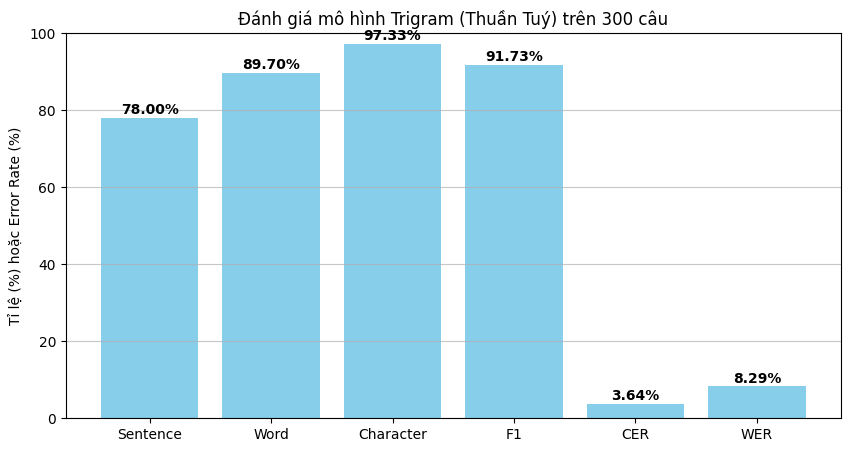

In [ ]:
print("Preparing for model evaluation...")

# Prepare evaluation data
print("\nLoading and splitting corpus for evaluation...")
_, test_set = load_and_split_corpus(data_extract_path=TRAIN_EXTRACT_PATH, test_size=TEST_SET_SIZE, random_seed=RANDOM_SEED)

if test_set:
    print(f"Loaded {len(test_set)} test items for evaluation.")

    # Limit test set size for faster evaluation
    MAX_EVAL_ITEMS = 50
    if len(test_set) > MAX_EVAL_ITEMS:
        print(f"Limiting evaluation to first {MAX_EVAL_ITEMS} items to save time...")
        test_set = test_set[:MAX_EVAL_ITEMS]

    # TỐI ƯU: Tải mô hình một lần duy nhất
    print("\nLoading model for evaluation...")
    model = load_model(DEFAULT_MODEL_PATH)
    if isinstance(model, dict) and "n" in model and "vocab" in model:
        model = CustomNGramModel(model)

    # Đánh giá cải tiến với mô hình đã tải
    def evaluate_item(item_data):
        unaccented_input_str, tokenized_true_accented_sent = item_data
        true_accented_str = _detokenizer.detokenize(tokenized_true_accented_sent)

        if model is None:
            return {
                "input_unaccented": unaccented_input_str,
                "true_accented": true_accented_str,
                "predicted_accented": "MODEL_LOAD_ERROR"
            }

        predictions = beam_search_predict_accents(
            text_no_accents=unaccented_input_str,
            model=model,
            k=BEAM_K,
            syllables_path=SYLLABLES_PATH
        )

        predicted_accented_str = predictions[0][0] if predictions else ""

        return {
            "input_unaccented": unaccented_input_str,
            "true_accented": true_accented_str,
            "predicted_accented": predicted_accented_str
        }

    # Evaluate each test item
    print("\nRunning predictions on test items...")
    evaluation_results = []

    from tqdm.notebook import tqdm
    for item in tqdm(test_set, desc="Evaluating"):
        result = evaluate_item(item)
        evaluation_results.append(result)

    # --- Các hàm bổ sung ---
    def f1_score(pred, ref):
        pred_words = set(pred.strip().split())
        ref_words = set(ref.strip().split())
        if not pred_words or not ref_words:
            return 0.0
        tp = len(pred_words & ref_words)
        fp = len(pred_words - ref_words)
        fn = len(ref_words - pred_words)
        if tp == 0:
            return 0.0
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        if precision + recall == 0:
            return 0.0
        return 2 * precision * recall / (precision + recall)

    def character_error_rate(pred, ref):
        pred_str = pred.strip()
        ref_str = ref.strip()
        if not ref_str:
            return 1.0
        from nltk.metrics.distance import edit_distance
        dist = edit_distance(pred_str, ref_str)
        return dist / len(ref_str)

    def word_error_rate(pred, ref):
        pred_words = pred.strip().split()
        ref_words = ref.strip().split()
        if not ref_words:
            return 1.0
        from nltk.metrics.distance import edit_distance
        dist = edit_distance(pred_words, ref_words)
        return dist / len(ref_words)

    # Calculate metrics
    print("\nCalculating evaluation metrics...")
    sent_accuracy = calculate_sentence_accuracy(evaluation_results)
    word_accuracy = calculate_word_accuracy(evaluation_results)
    char_error_rate_val = calculate_cer(evaluation_results)
    char_accuracy = 100.0 - char_error_rate_val

    f1 = sum([f1_score(r['predicted_accented'], r['true_accented']) for r in evaluation_results]) / len(evaluation_results) * 100
    cer = sum([character_error_rate(r['predicted_accented'], r['true_accented']) for r in evaluation_results]) / len(evaluation_results) * 100
    wer = sum([word_error_rate(r['predicted_accented'], r['true_accented']) for r in evaluation_results]) / len(evaluation_results) * 100

    # Display metrics
    print(f"\n--- Evaluation Metrics ---")
    print(f"Sentence Accuracy: {sent_accuracy:.2f}%")
    print(f"Word Accuracy: {word_accuracy:.2f}%")
    print(f"Character Error Rate (CER): {char_error_rate_val:.2f}%")
    print(f"Character Accuracy: {char_accuracy:.2f}%")
    print(f"F1-Score: {f1:.2f}%")
    print(f"Character Error Rate (CER, trung bình): {cer:.2f}%")
    print(f"Word Error Rate (WER): {wer:.2f}%")

    # Save results
    results_file_path = os.path.join(BASE_DIR, RESULTS_FILE)
    try:
        with open(results_file_path, 'w', encoding='utf-8') as f:
            json.dump(evaluation_results, f, ensure_ascii=False, indent=4)
        print(f"\nResults saved to {results_file_path}")
    except IOError as e:
        print(f"Error saving results: {e}")

    # Display sample results
    display_sample_results(evaluation_results, num_samples=5)

    # Plot metrics using the improved plot_metrics function
    metrics_to_plot = {
        "Sentence Accuracy": sent_accuracy,
        "Word Accuracy": word_accuracy,
        "Character Accuracy": char_accuracy,
        "F1-Score": f1,
        "CER": cer,
        "WER": wer
    }
    plot_metrics(metrics_to_plot, plot_types=['bar', 'radar'])

else:
    print("Test set could not be loaded. Skipping evaluation.")

metrics_demo = evaluate_on_dataset(sample_300, sample_size=300)

## 11. Interactive Prediction Demo

In [ ]:
def run_prediction_demo():
    # Load the model
    model = load_model(DEFAULT_MODEL_PATH)
    if not model:
        print("Model could not be loaded. Cannot run prediction demo.")
        return

    print("--- Vietnamese Accent Predictor Demo ---")
    print("Enter Vietnamese text without accents to predict the accented version.")
    print("Type 'exit' to quit.")

    from nltk.metrics.distance import edit_distance

    while True:
        text_input = input("\nNhập câu tiếng Việt không dấu: ")
        if text_input.lower() == 'exit':
            break
        if not text_input.strip():
            print("Please enter a sentence.")
            continue

        print(f"Predicting accents for: '{text_input}'")
        predictions = beam_search_predict_accents(
            text_input,
            model,
            k=3
        )

        if predictions:
            print("\nTop predictions:")
            for i, (sent, score) in enumerate(predictions):
                print(f"{i+1}. '{sent}' (Score: {score:.4f})")

            # Thêm phần đánh giá với văn bản chuẩn
            ref_text = input("\nNhập câu chuẩn có dấu để đánh giá (bỏ qua nếu không có): ")
            if ref_text.strip():
                # Lấy dự đoán tốt nhất để đánh giá
                best_prediction = predictions[0][0]

                # Sentence Accuracy
                sentence_acc = 1.0 if best_prediction.strip() == ref_text.strip() else 0.0

                # Word Accuracy
                ref_words = ref_text.strip().split()
                pred_words = best_prediction.strip().split()
                correct_words = 0
                len_min = min(len(pred_words), len(ref_words))

                for i in range(len_min):
                    if pred_words[i] == ref_words[i]:
                        correct_words += 1
                word_acc = correct_words / len(ref_words) if ref_words else 0.0

                # Character Accuracy
                pred_str = best_prediction.strip()
                ref_str = ref_text.strip()
                dist = edit_distance(pred_str, ref_str)
                char_acc = 1.0 - (dist / len(ref_str)) if ref_str else 0.0

                # In kết quả đánh giá
                print("\n--- Kết quả đánh giá ---")
                print(f"Câu tham chiếu: '{ref_text}'")
                print(f"Câu dự đoán:    '{best_prediction}'")
                print(f"Sentence Accuracy: {sentence_acc * 100:.2f}%")
                print(f"Word Accuracy:     {word_acc * 100:.2f}%")
                print(f"Character Accuracy: {char_acc * 100:.2f}%")
                print("------------------------")
        else:
            print("No predictions returned.")

    print("\n--- Demo Finished ---")

# Run the interactive demo
run_prediction_demo()

Attempting to load model from /content/models/kneserney_trigram_model.pkl...
Model loaded successfully. Vocabulary size: 104810
--- Vietnamese Accent Predictor Demo ---
Enter Vietnamese text without accents to predict the accented version.
Type 'exit' to quit.

Nhập câu tiếng Việt không dấu: toi dep trai
Predicting accents for: 'toi dep trai'

Top predictions:
1. 'tõi đẹp trải' (Score: -46.0517)
2. 'tõi đẹp trai' (Score: -46.0517)
3. 'tõi đẹp trãi' (Score: -46.0517)

Nhập câu chuẩn có dấu để đánh giá (bỏ qua nếu không có): tôi đẹp trai

--- Kết quả đánh giá ---
Câu tham chiếu: 'tôi đẹp trai'
Câu dự đoán:    'tõi đẹp trải'
Sentence Accuracy: 0.00%
Word Accuracy:     33.33%
Character Accuracy: 83.33%
------------------------

Nhập câu tiếng Việt không dấu: tôi thông minh
Predicting accents for: 'tôi thông minh'

Top predictions:
1. 'tôi thông minh' (Score: -9.2596)
2. 'tôi thông mình' (Score: -33.8949)
3. 'tôi thông mịnh' (Score: -33.8949)

Nhập câu chuẩn có dấu để đánh giá (bỏ qua nếu k

In [19]:
# Porting evaluator code
import json
from nltk.metrics.distance import edit_distance

RESULTS_FILE = "evaluation_results.json"
TEST_SET_SIZE = 0.2
RANDOM_SEED = 42
BEAM_K = 3

def _predict_item(item_data: tuple):
    """
    Dự đoán dấu cho một mục từ tập dữ liệu kiểm thử

    Args:
        item_data: Tuple gồm (chuỗi không dấu, danh sách token có dấu)

    Returns:
        Dictionary chứa đầu vào, kết quả đúng, và dự đoán
    """
    unaccented_input_str, tokenized_true_accented_sent = item_data
    true_accented_str = _detokenizer.detokenize(tokenized_true_accented_sent)

    # Tải model - chỉ cần tải 1 lần bên ngoài và truyền vào sẽ tốt hơn
    model = load_model(DEFAULT_MODEL_PATH)
    if model is None:
        return {
            "input_unaccented": unaccented_input_str,
            "true_accented": true_accented_str,
            "predicted_accented": "MODEL_LOAD_ERROR"
        }

    # Chuyển đổi từ điển sang CustomNGramModel nếu cần
    if isinstance(model, dict) and "n" in model and "vocab" in model:
        model = CustomNGramModel(model)

    # Dự đoán sử dụng beam search
    predictions = beam_search_predict_accents(
        text_no_accents=unaccented_input_str,
        model=model,
        k=BEAM_K,
        syllables_path=SYLLABLES_PATH  # Tham số đã được sửa để khớp
    )

    predicted_accented_str = predictions[0][0] if predictions else ""

    return {
        "input_unaccented": unaccented_input_str,
        "true_accented": true_accented_str,
        "predicted_accented": predicted_accented_str
    }

def calculate_sentence_accuracy(results: list[dict]) -> float:
    if not results:
        return 0.0
    correct_sentences = 0
    for res in results:
        if res["true_accented"].strip() == res["predicted_accented"].strip():
            correct_sentences += 1
    return (correct_sentences / len(results)) * 100

def calculate_word_accuracy(results: list[dict]) -> float:
    if not results:
        return 0.0
    total_words = 0
    correct_words = 0
    for res in results:
        true_words = res["true_accented"].strip().split()
        predicted_words = res["predicted_accented"].strip().split()
        len_min = min(len(true_words), len(predicted_words))
        for i in range(len_min):
            if true_words[i] == predicted_words[i]:
                correct_words += 1
        total_words += len(true_words)
    if total_words == 0: return 0.0
    return (correct_words / total_words) * 100

def calculate_cer(results: list[dict]) -> float:
    if not results:
        return 0.0
    total_edit_distance = 0
    total_true_chars = 0
    for res in results:
        true_str = res["true_accented"].strip()
        pred_str = res["predicted_accented"].strip()
        if not true_str and not pred_str:
            dist = 0
        elif not true_str:
            dist = len(pred_str)
        elif not pred_str:
            dist = len(true_str)
        else:
            dist = edit_distance(pred_str, true_str)
        total_edit_distance += dist
        total_true_chars += len(true_str)
    if total_true_chars == 0: return 1.0 if total_edit_distance > 0 else 0.0
    return (total_edit_distance / total_true_chars) * 100


def f1_score(pred, ref):
    pred_words = set(pred.strip().split())
    ref_words = set(ref.strip().split())
    if not pred_words or not ref_words:
        return 0.0
    tp = len(pred_words & ref_words)
    fp = len(pred_words - ref_words)
    fn = len(ref_words - pred_words)
    if tp == 0:
        return 0.0
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

# Character Error Rate (CER)
def character_error_rate(pred, ref):
    pred_str = pred.strip()
    ref_str = ref.strip()
    if not ref_str:
        return 1.0
    dist = edit_distance(pred_str, ref_str)
    return dist / len(ref_str)

# Word Error Rate (WER)
def word_error_rate(pred, ref):
    pred_words = pred.strip().split()
    ref_words = ref.strip().split()
    if not ref_words:
        return 1.0
    dist = edit_distance(pred_words, ref_words)
    return dist / len(ref_words)


def display_sample_results(results: list[dict], num_samples: int = 5):
    print("\n--- Sample Predictions ---")
    for i, res in enumerate(results[:num_samples]):
        print(f"Sample {i+1}:")
        print(f"  Input:     '{res['input_unaccented']}'")
        print(f"  True:      '{res['true_accented']}'")
        print(f"  Predicted: '{res['predicted_accented']}'")
        print("---")

def plot_metrics(metrics: dict, plot_types=['bar', 'radar']):
    """
    Plots evaluation metrics using matplotlib and seaborn.
    Supports multiple visualization types: bar chart and radar chart.
    """
    import os
    import matplotlib.pyplot as plt
    import numpy as np

    # Try to import seaborn for better aesthetics
    try:
        import seaborn as sns
        sns.set_theme(style="whitegrid")
    except ImportError:
        pass

    names = list(metrics.keys())
    values = list(metrics.values())

    # Bar Chart
    if 'bar' in plot_types:
        plt.figure(figsize=(10, 5))
        bars = plt.bar(names, values, color=sns.color_palette("viridis", len(names)) if 'sns' in globals() else None)
        plt.ylabel('Tỉ lệ (%) hoặc Error Rate (%)', fontsize=13)
        plt.title('Model Evaluation Metrics (Bar Chart)', fontsize=15, fontweight='bold')
        for i, bar in enumerate(bars):
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', va='bottom', fontsize=11)
        plt.tight_layout()
        plt.show()

    # Radar/Spider Chart
    if 'radar' in plot_types and len(metrics) > 2:
        # Radar chart needs the data to be circular
        values_radar = values + [values[0]]
        labels_radar = names + [names[0]]
        angles = np.linspace(0, 2 * np.pi, len(labels_radar), endpoint=True)

        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, polar=True)
        ax.plot(angles, values_radar, 'o-', linewidth=2, label='Metrics')
        ax.fill(angles, values_radar, alpha=0.25)
        ax.set_thetagrids(angles * 180/np.pi, labels_radar)
        ax.set_title('Model Evaluation Metrics (Radar Chart)', fontsize=15, fontweight='bold', pad=20)
        ax.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_DIR, "evaluation_metrics_radar.png"))
        plt.show()

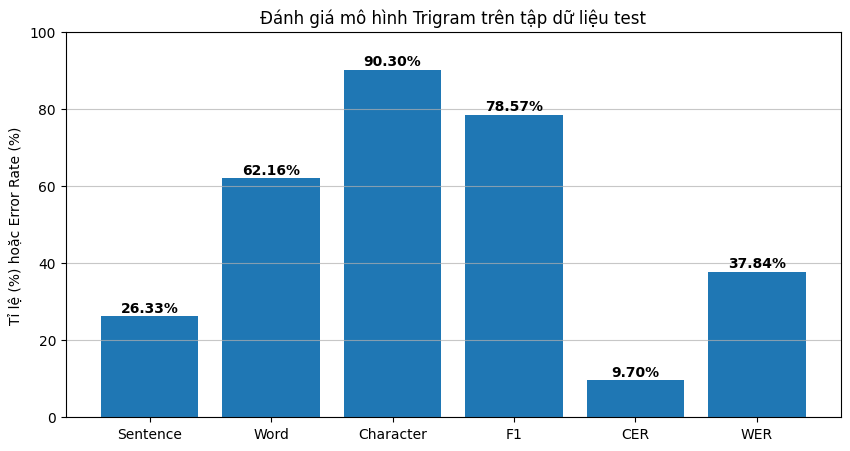

In [ ]:
# Main function to run the evaluation
# Configure paths
BASE_DIR = os.getcwd()
MODEL_DIR = os.path.join(BASE_DIR, "models")
DATA_DIR = os.path.join(BASE_DIR, "data")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
RESULTS_FILE = "evaluation_results_from_test.json"

# Model paths
MODEL_PATH = os.path.join(MODEL_DIR, "kneserney_trigram_model.pkl")
SYLLABLES_PATH = os.path.join(DATA_DIR, "vn_syllables.txt")

# Test data paths
TEST_FILE = os.path.join(BASE_DIR, "test.txt")
GROUND_TRUTH_FILE = os.path.join(BASE_DIR, "test_result.txt")

# Ensure output directories exist
os.makedirs(PLOTS_DIR, exist_ok=True)

# Create a detokenizer
_detokenizer = TreebankWordDetokenizer()

def evaluate_model_on_test_file():
    print("=== Vietnamese Accent Prediction Evaluation ===")

    # Load the model
    model = load_model(MODEL_PATH)
    if model is None:
        print("Failed to load model. Exiting.")
        return

    # Check if test and ground truth files exist
    if not os.path.exists(TEST_FILE):
        print(f"Test file not found: {TEST_FILE}")
        return

    if not os.path.exists(GROUND_TRUTH_FILE):
        print(f"Ground truth file not found: {GROUND_TRUTH_FILE}")
        return

    # Read test data and ground truth
    try:
        with open(TEST_FILE, 'r', encoding='utf-8') as f:
            test_lines = [line.strip() for line in f.readlines() if line.strip()]

        with open(GROUND_TRUTH_FILE, 'r', encoding='utf-8') as f:
            ground_truth_lines = [line.strip() for line in f.readlines() if line.strip()]

        if len(test_lines) != len(ground_truth_lines):
            print(f"Warning: Test file has {len(test_lines)} non-empty lines, but ground truth has {len(ground_truth_lines)}.")
            print("Will evaluate only on paired lines.")
    except Exception as e:
        print(f"Error reading test files: {e}")
        return

    # Prepare for evaluation
    print(f"\nEvaluating on {min(len(test_lines), len(ground_truth_lines))} sentences...")
    evaluation_results = []

    # Process each line
    for i, (test_line, true_line) in enumerate(zip(test_lines, ground_truth_lines)):
        print(f"Processing sentence {i+1}/{min(len(test_lines), len(ground_truth_lines))}...", end='\r')

        # Make prediction
        predictions = beam_search_predict_accents(
            text_no_accents=test_line,
            model=model,
            k=3
            # syllables_file=SYLLABLES_PATH
        )

        predicted_text = predictions[0][0] if predictions else ""

        # Store result
        result = {
            "input_unaccented": test_line,
            "true_accented": true_line,
            "predicted_accented": predicted_text
        }
        evaluation_results.append(result)

    print("\nCalculating evaluation metrics...")

    # Calculate metrics
    sent_accuracy = calculate_sentence_accuracy(evaluation_results)
    word_accuracy = calculate_word_accuracy(evaluation_results)
    char_error_rate = calculate_cer(evaluation_results)
    char_accuracy = 100.0 - char_error_rate
    f1 = sum([f1_score(r['predicted_accented'], r['true_accented']) for r in evaluation_results]) / len(evaluation_results) * 100
    # Display metrics
    print("\n=== Evaluation Metrics ===")
    print(f"Sentence Accuracy: {sent_accuracy:.2f}%")
    print(f"Word Accuracy: {word_accuracy:.2f}%")
    print(f"f1-Score: {f1:.2f}%")
    print(f"Character Error Rate (CER): {char_error_rate:.2f}%")
    print(f"Character Accuracy: {char_accuracy:.2f}%")

    # Save results to file
    try:
        with open(os.path.join(BASE_DIR, RESULTS_FILE), 'w', encoding='utf-8') as f:
            json.dump(evaluation_results, f, ensure_ascii=False, indent=4)
        print(f"\nResults saved to {os.path.join(BASE_DIR, RESULTS_FILE)}")
    except Exception as e:
        print(f"Error saving results: {e}")

    # Display sample results
    display_sample_results(evaluation_results, num_samples=5)

    # Plot metrics
    metrics_to_plot = {
        "Sentence Accuracy": sent_accuracy,
        "Word Accuracy": word_accuracy,
        "Character Accuracy": char_accuracy,
        "F1-Score": f1,
    }
    plot_metrics(metrics_to_plot, plot_types=['bar'])

    return evaluation_results, metrics_to_plot

# Run the evaluation
if __name__ == "__main__":
    evaluate_model_on_test_file()